In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

from configuration.settings import settings

In [2]:
# Datasets need it to build this project are available at: https://www.kaggle.com/competitions/playground-series-s5e4/overview

base_path = 'local_files/podcast_time_prediction/'

# Load the training data
raw_train = pd.read_csv(base_path + 'train.csv', index_col='id')
raw_test = pd.read_csv(base_path + 'test.csv', index_col='id')
print(raw_train.shape)
print(raw_test.shape)


(750000, 11)
(250000, 10)


# EDA

In [18]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 750000 non-null  object 
 1   Episode_Title                750000 non-null  object 
 2   Episode_Length_minutes       662907 non-null  float64
 3   Genre                        750000 non-null  object 
 4   Host_Popularity_percentage   750000 non-null  float64
 5   Publication_Day              750000 non-null  object 
 6   Publication_Time             750000 non-null  object 
 7   Guest_Popularity_percentage  603970 non-null  float64
 8   Number_of_Ads                749999 non-null  float64
 9   Episode_Sentiment            750000 non-null  object 
 10  Listening_Time_minutes       750000 non-null  float64
dtypes: float64(5), object(6)
memory usage: 68.7+ MB


In [30]:
raw_train.groupby(['episode_number']).agg({'Episode_Length_minutes': 'mean', 'Listening_Time_minutes': 'mean', 'Podcast_Name': 'count'}).reset_index().sort_values(by='Listening_Time_minutes', ascending=False)

,episode_number,Episode_Length_minutes,Listening_Time_minutes,Podcast_Name
24,25,70.733971,51.221690,5117
44,45,70.687442,50.551025,6843
53,54,69.277799,49.343876,8342
58,59,69.892718,49.306814,7338
30,31,68.186889,49.269676,10292
...,...,...,...,...
37,38,61.205401,42.368371,6909
76,77,60.792776,42.092911,6232
97,98,60.225856,41.311952,5902
2,3,59.728404,41.225424,6943


### Mapping podcast name to use it as a numerical variable

In [3]:
# Check if all podcast name in test are in train
train_podcast = raw_train.Podcast_Name.unique().tolist()
test_podcast = raw_test.Podcast_Name.unique().tolist()
podcast_diff = set(train_podcast) - set(test_podcast)
print(f"Podcasts in train but not in test: {len(podcast_diff)}")

Podcasts in train but not in test: 0


In [4]:
podcast_impact = raw_train.groupby(['Podcast_Name']).agg({'Episode_Length_minutes': 'mean', 'Listening_Time_minutes': 'mean', 'Episode_Title': 'count'}).reset_index().sort_values(by='Listening_Time_minutes', ascending=False)
podcast_impact['podcast_name_quartile'] = pd.qcut(podcast_impact['Listening_Time_minutes'], q=5, labels=[1, 2, 3, 4, 5])
podcast_impact['podcast_name_importance'] = podcast_impact.groupby(['podcast_name_quartile'])['Listening_Time_minutes'].rank(method='min', ascending=True)
podcast_impact['podcast_name_importance'] = podcast_impact['podcast_name_importance']/100
podcast_impact['podcast_name_importance_value'] = podcast_impact['podcast_name_quartile'].astype(int) + podcast_impact['podcast_name_importance']
podcast_impact.head()

C:\Users\Dell\AppData\Local\Temp\ipykernel_27044\443262023.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  podcast_impact['podcast_name_importance'] = podcast_impact.groupby(['podcast_name_quartile'])['Listening_Time_minutes'].rank(method='min', ascending=True)


,Podcast_Name,Episode_Length_minutes,Listening_Time_minutes,Episode_Title,podcast_name_quartile,podcast_name_importance,podcast_name_importance_value
30,Melody Mix,67.909736,48.105553,18889,5,0.10,5.10
32,Money Matters,66.897096,47.883883,13380,5,0.09,5.09
5,Crime Chronicles,66.095907,47.678948,17374,5,0.08,5.08
2,Business Briefs,66.672731,47.121103,17012,5,0.07,5.07
40,Study Sessions,65.980351,47.047780,13053,5,0.06,5.06


In [6]:
podcast_map = podcast_impact[['Podcast_Name', 'podcast_name_importance_value']].set_index('Podcast_Name').to_dict()['podcast_name_importance_value']

c:\Users\Dell\Documents\repositories\ml_models\venv\lib\site-packages\seaborn\axisgrid.py:2100: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


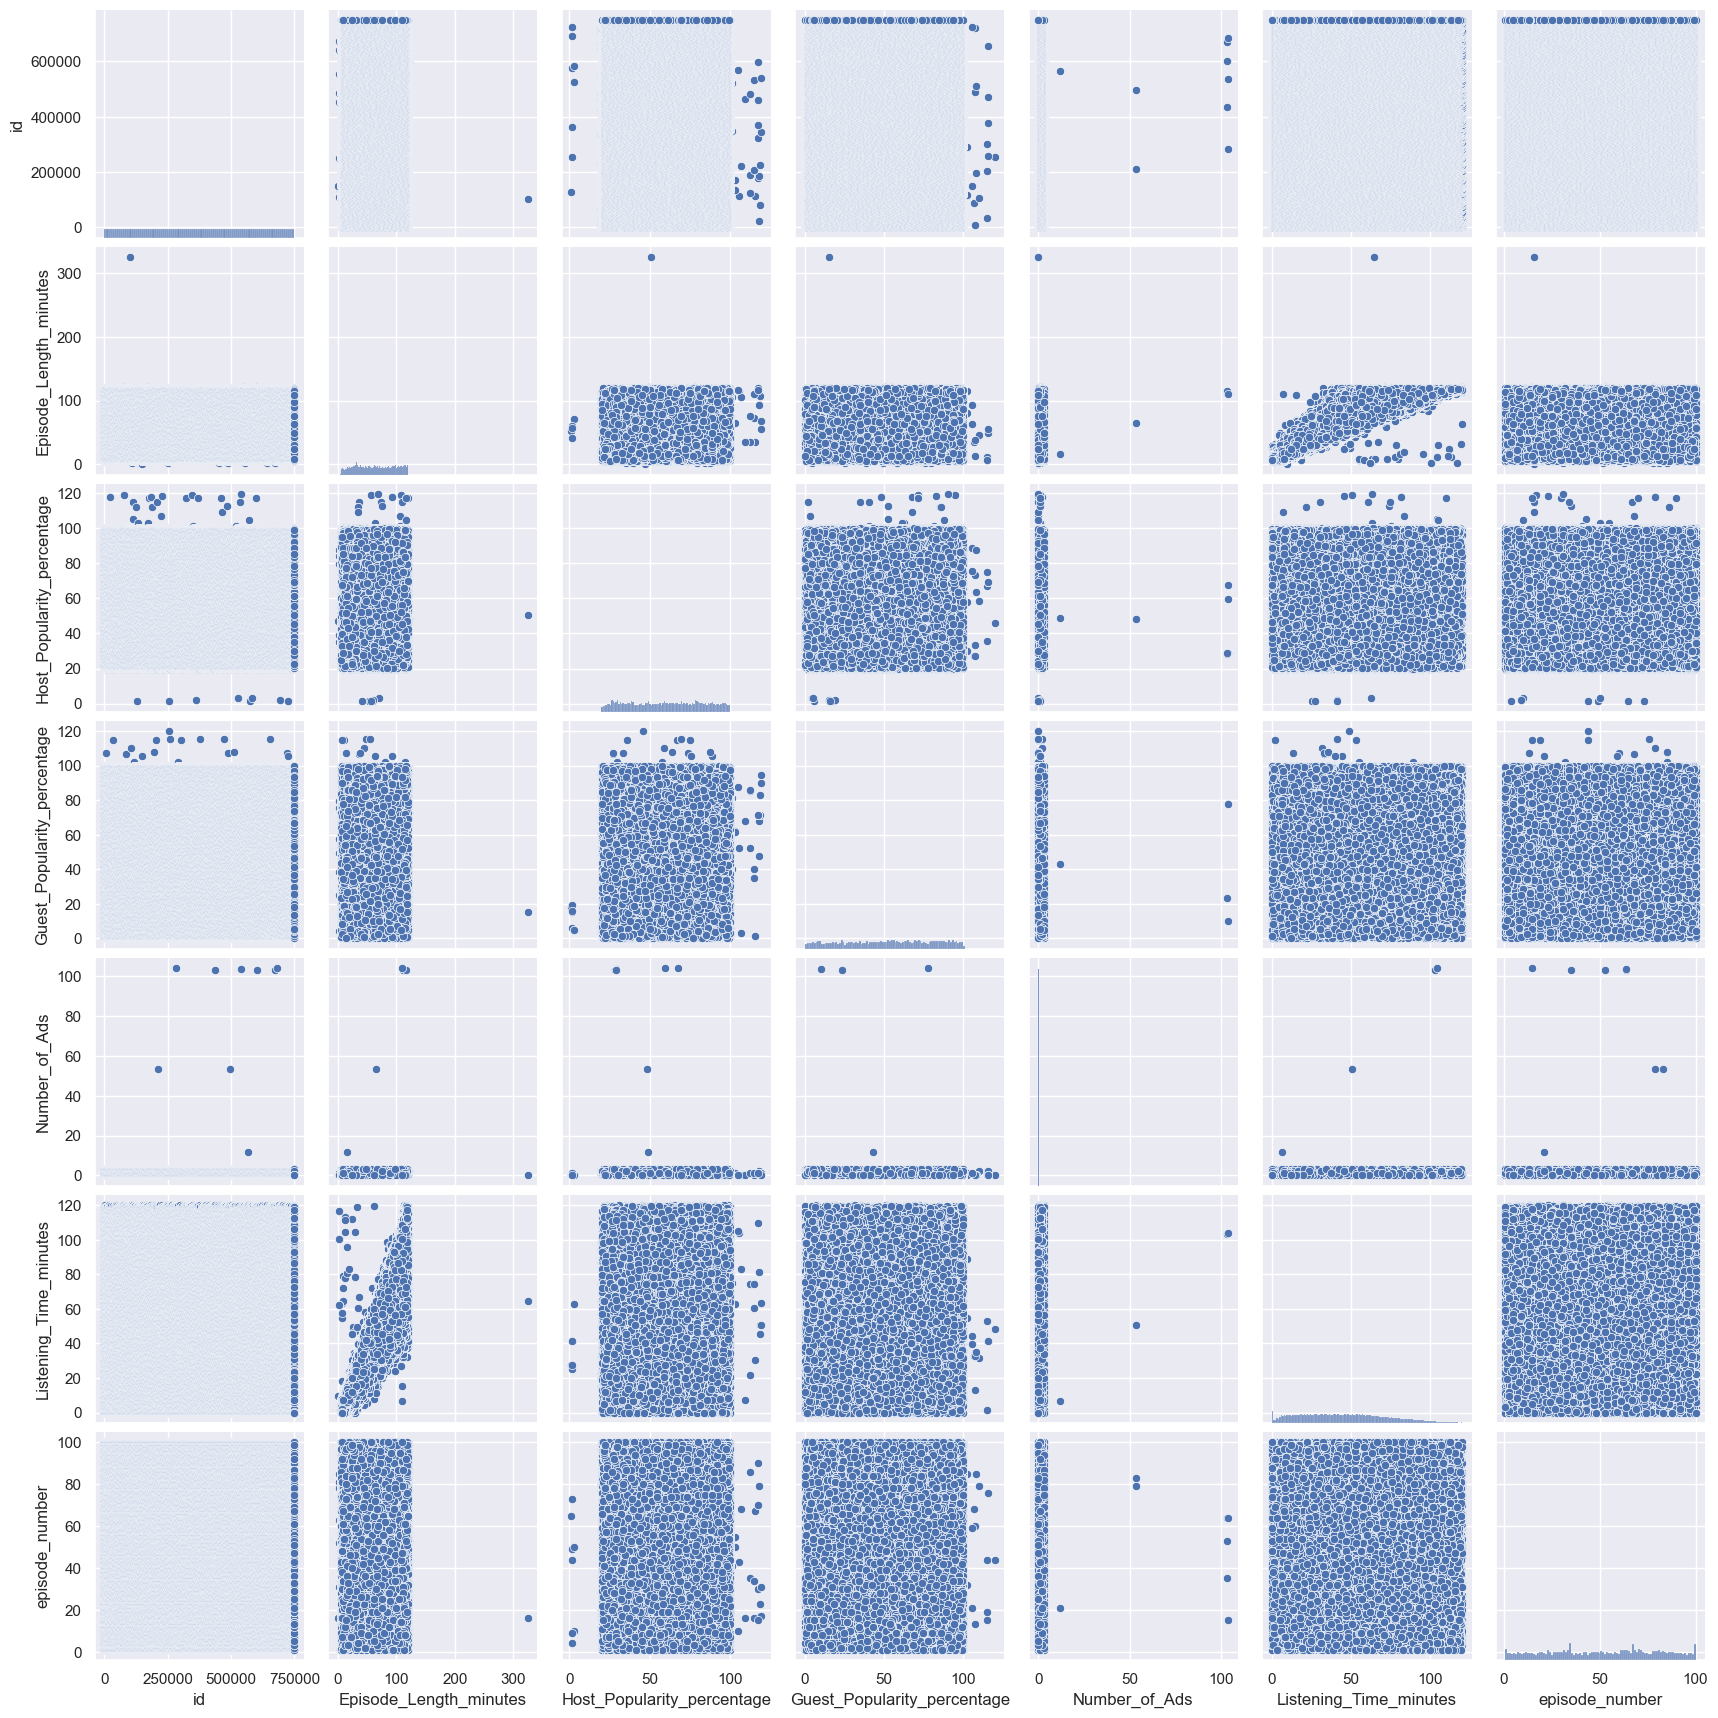

In [ ]:
# -----------------------------------------Pair plot -------------------------------------------
# # variables summary
cols = raw_train.columns.tolist()
sns.set()
sns.pairplot(raw_train[cols], size = 2.5)
plt.show()

### Missing values

In [6]:
# Percentage of missing values in the dataset for Episode_Length_minutes column

raw_train[raw_train['Episode_Length_minutes'].isnull()].shape[0] / raw_train.shape[0]

0.116124

In [13]:
# Percentage of missing values in the dataset for Guest_Popularity_percentage column
raw_train[raw_train['Guest_Popularity_percentage'].isnull()].shape[0] / raw_train.shape[0]

0.19470666666666667

In [21]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 750000 non-null  object 
 1   Episode_Title                750000 non-null  object 
 2   Episode_Length_minutes       662907 non-null  float64
 3   Genre                        750000 non-null  object 
 4   Host_Popularity_percentage   750000 non-null  float64
 5   Publication_Day              750000 non-null  object 
 6   Publication_Time             750000 non-null  object 
 7   Guest_Popularity_percentage  603970 non-null  float64
 8   Number_of_Ads                749999 non-null  float64
 9   Episode_Sentiment            750000 non-null  object 
 10  Listening_Time_minutes       750000 non-null  float64
 11  episode_number               750000 non-null  int64  
dtypes: float64(5), int64(1), object(6)
memory usage: 74.4+ MB


In [ ]:
# df_inputed.to_csv(base_path+'df_imputed_2.csv', index=False)

## Feature engineering

In [7]:
genre_map = {
    'Music': 0,         # 46.58 min (más escuchado)
    'True Crime': 1,    # 46.04 min
    'Health': 2,        # 45.74 min
    'Education': 3,     # 45.74 min
    'Technology': 4,    # 45.63 min
    'Business': 5,      # 45.54 min
    'Lifestyle': 6,     # 45.52 min
    'Sports': 7,        # 44.94 min
    'Comedy': 8,        # 44.43 min
    'News': 9           # 44.41 min (menos escuchado)
}

day_map = {
    'Tuesday': 0,     # 46.13 min (más escuchado)
    'Monday': 1,      # 45.97 min
    'Wednesday': 2,   # 45.81 min
    'Saturday': 3,    # 45.33 min
    'Friday': 4,      # 45.21 min
    'Thursday': 5,    # 44.87 min
    'Sunday': 6       # 44.82 min (menos escuchado)
}

time_map = {
    'Night': 0,      # 46.46 min (más escuchado)
    'Afternoon': 1,  # 45.53 min
    'Morning': 2,    # 44.96 min
    'Evening': 3     # 44.76 min (menos escuchado)
}

sentiment_map = {'Neutral': 0, 'Positive': 1, 'Negative': -1}

def impute_missing_values(raw_df):
    numerical_columns = raw_df.select_dtypes(include=['int', 'float']).columns.tolist()
    complete_columns = list(set(numerical_columns) - set(['Listening_Time_minutes']))

    test_imputed_data = []
    # to impute missing values but filtering by specific segment of the data
    for podcast_name, group in raw_df.groupby('Podcast_Name'):
        test_imputer = KNNImputer(n_neighbors=5)
        test_features = group[complete_columns]
        test_imputed_values = test_imputer.fit_transform(test_features)
        group[complete_columns] = test_imputed_values
        test_imputed_data.append(group)

    # Reconstruimos el DataFrame final con todos los clusters
    df_imputed = pd.concat(test_imputed_data).sort_index()
    return df_imputed

def impute_missing_values(raw_df):
    numerical_columns = raw_df.select_dtypes(include=['int', 'float']).columns.tolist()
    complete_columns = list(set(numerical_columns) - set(['Listening_Time_minutes']))

    test_imputed_data = []
    # to impute missing values but filtering by specific segment of the data
    for podcast_name, group in raw_df.groupby('Podcast_Name'):
        test_imputer = KNNImputer(n_neighbors=5)
        test_features = group[complete_columns]
        test_imputed_values = test_imputer.fit_transform(test_features)
        group[complete_columns] = test_imputed_values
        test_imputed_data.append(group)

    # Reconstruimos el DataFrame final con todos los clusters
    df_imputed = pd.concat(test_imputed_data).sort_index()
    return df_imputed    

def feature_engineering(raw_train_0):
    raw_train = raw_train_0.copy()

    # extract episode number from the title
    raw_train['episode_number'] = raw_train['Episode_Title'].str.extract(r'(\d+)').astype(int)
    raw_train['episode_number_quartile'] = pd.qcut(raw_train['episode_number'], q=5, labels=[1, 2, 3, 4, 5]).astype(int)

    # deal with missing values
    # raw_train['null_values'] = raw_train.isnull().sum(axis=1)
    # raw_train = impute_missing_values(raw_train)
    raw_train['Episode_Length_minutes_null'] = raw_train['Episode_Length_minutes'].isnull().astype(int)
    raw_train['Guest_Popularity_percentage_null'] = raw_train['Guest_Popularity_percentage'].isnull().astype(int)
    raw_train['Episode_Length_minutes'] = raw_train['Episode_Length_minutes'].fillna(raw_train.groupby('Podcast_Name')['Episode_Length_minutes'].transform('median'))
    raw_train['Guest_Popularity_percentage'] = raw_train['Guest_Popularity_percentage'].fillna(raw_train.groupby('Podcast_Name')['Guest_Popularity_percentage'].transform('median'))
    raw_train['Number_of_Ads'] = raw_train['Number_of_Ads'].fillna(raw_train.groupby('Podcast_Name')['Guest_Popularity_percentage'].transform('median'))

    # mapping categorical variables to numerical values
    raw_train['sentiment_encode'] = raw_train['Episode_Sentiment'].map(sentiment_map)
    raw_train['publication_time_encode'] = raw_train['Publication_Time'].map(time_map)
    raw_train['day_encode'] = raw_train['Publication_Day'].map(day_map)
    raw_train ['genre_encode'] = raw_train['Genre'].map(genre_map)
    raw_train['podcast_name_encode'] = raw_train['Podcast_Name'].map(podcast_map)

    # feture relationship
    raw_train['ad_density'] = raw_train['Number_of_Ads'] / raw_train['Episode_Length_minutes']
    raw_train['popularity_delta'] = raw_train['Host_Popularity_percentage'] - raw_train['Guest_Popularity_percentage']
    raw_train['popularity_multiplication'] = raw_train['Host_Popularity_percentage'] * raw_train['Guest_Popularity_percentage']
    raw_train['popularity_division'] = np.where(raw_train['Guest_Popularity_percentage'] == 0,0,raw_train['Host_Popularity_percentage'] / raw_train['Guest_Popularity_percentage'])
    raw_train['host_pop_square'] = raw_train['Host_Popularity_percentage'] ** 2
    raw_train['guest_pop_square'] = raw_train['Guest_Popularity_percentage'] ** 2
    raw_train['popularity_avg' ] = (raw_train['Host_Popularity_percentage'] + raw_train['Guest_Popularity_percentage']) / 2
    raw_train['popularity_guest_host'] = raw_train['Guest_Popularity_percentage'] / (raw_train['Host_Popularity_percentage'] + 1e-3)
    raw_train['episode_lengh_bins'] = pd.cut(raw_train['Episode_Length_minutes'], bins=[0, 30, 60, 90, 150, 200], labels=[1, 2, 3, 4, 5]).astype('Int64')
    raw_train['is_weekend'] = np.where(raw_train['Publication_Day'].isin(['Saturday', 'Sunday']), 1, 0)
    raw_train['is_morning'] = np.where(raw_train['Publication_Time'].isin(['Morning']), 1, 0)
    raw_train['is_night'] = np.where(raw_train['Publication_Time'].isin(['Night']), 1, 0)
    # drop unnecessary columns
    df_encode = raw_train.drop(columns=['Podcast_Name','Episode_Title', 'Episode_Sentiment', 'Publication_Time', 'Publication_Day','Genre'])
    return df_encode

df_train = feature_engineering(raw_train)

In [ ]:
# df_train.replace([np.inf, -np.inf], 0, inplace=True)
# df_train.isin([np.inf, -np.inf]).any()

### Add podcast name vectorized

In [18]:
vectorizer = TfidfVectorizer()
tfidf_train = vectorizer.fit_transform(raw_train['Podcast_Name'])
feature_names = vectorizer.get_feature_names_out()
tfidf_train_df = pd.DataFrame(tfidf_train.toarray(), columns=feature_names)
tfidf_test = vectorizer.transform(raw_test['Podcast_Name'])
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=feature_names)

In [19]:
df_train_tfidf = pd.concat([df_train, tfidf_train_df], axis=1)

# Model training

In [ ]:
# df_path = 'local_files/podcast_time_prediction/train_processed.csv'
# df_train = pd.read_csv(df_path)

In [8]:
all_columns = df_train.columns.tolist()
columns_to_exclude = ['Listening_Time_minutes'] 
x_features = [col for col in all_columns if col not in columns_to_exclude]
# df_rf = df_train_tfidf.copy()
df_rf = df_train.copy()
# df_rf.info()
x_features

['Episode_Length_minutes',
 'Host_Popularity_percentage',
 'Guest_Popularity_percentage',
 'Number_of_Ads',
 'episode_number',
 'episode_number_quartile',
 'Episode_Length_minutes_null',
 'Guest_Popularity_percentage_null',
 'sentiment_encode',
 'publication_time_encode',
 'day_encode',
 'genre_encode',
 'podcast_name_encode',
 'ad_density',
 'popularity_delta',
 'popularity_multiplication',
 'popularity_division',
 'host_pop_square',
 'guest_pop_square',
 'popularity_avg',
 'popularity_guest_host',
 'episode_lengh_bins',
 'is_weekend',
 'is_morning',
 'is_night']

In [9]:

X = df_rf[x_features]
y = df_rf['Listening_Time_minutes']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# X_train_final, X_valid, y_train_final, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# XGBOOST Model with comet ML monitoring

In [ ]:
from comet_ml import Experiment
import xgboost as xgb

# Step 1: Start a Comet experiment
experiment = Experiment(
    api_key=settings.COMET_ML_API_KEY,          # Replace with your actual key
    project_name="listening-time-prediction",    # You can customize this
    workspace=settings.COMET_ML_WORKSPACE       # Your Comet username
)

# Log experiment metadata
experiment.set_name("XGBoost GPU - no tfidf")
experiment.log_dataset_hash(X_train)
experiment.log_parameter("model_type", "XGBRegressor")

# Step 2: Create the model
params = {
    'n_estimators': 3500,
    'learning_rate': 0.032,
    'max_depth': 15,
    'min_child_weight': 5,
    'random_state': 42,
    'n_jobs': -2,
    'tree_method': 'gpu_hist',
    'subsample': 0.8,
    'gamma': 1
}
experiment.log_parameters(params)

model_xgb_comet = xgb.XGBRegressor(**params)

# Step 3: Train the model
model_xgb_comet.fit(X_train, y_train)

# Log best iteration
# experiment.log_parameter("best_iteration", model_xgb_comet.best_iteration)

# Step 4: Predict and evaluate
y_pred = model_xgb_comet.predict(X_test)

# Calcular el Error Cuadrático Medio
mse = mean_squared_error(y_test, y_pred)
# print(f"Mean Squared Error: {mse}")

# Calcular el R²
r2 = r2_score(y_test, y_pred)
# print(f"R² Score xgboost: {r2}")

rmse = np.sqrt(mse)
# print(f"Root Mean Squared Error (RMSE) xgboost: {rmse}")

experiment.log_metric("RMSE", rmse)
experiment.log_metric("R2", r2)
experiment.log_metric("MSE", mse)

# Optional: Log the model
# model_xgb_comet.save_model("model_xgb_comet.json")
# experiment.log_model("xgb_model", "model_xgb_comet.json")
experiment.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/icondor2019/listening-time-prediction/9c5edb6b8082400d917f261eaf043fd1

c:\Users\Dell\Documents\repositories\ml_models\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [18:21:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
COMET WARNING: You must install graphviz to plot tree
c:\Users\Dell\Documents\repositories\ml_models\venv\lib\site-packages\xgboost\core.py:2676: UserWarning: [18:28:56] WAR

{'web': 'https://www.comet.com/api/asset/download?assetId=e6f3f1f75d84457eb7d81b23292f194a&experimentKey=9c5edb6b8082400d917f261eaf043fd1',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=e6f3f1f75d84457eb7d81b23292f194a&experimentKey=9c5edb6b8082400d917f261eaf043fd1',
 'assetId': 'e6f3f1f75d84457eb7d81b23292f194a'}

In [12]:
# Calcular el Error Cuadrático Medio
print(f"Mean Squared Error: {mse}")

# Calcular el R²
print(f"R² Score xgboost: {r2}")

print(f"Root Mean Squared Error (RMSE) xgboost: {rmse}")

Mean Squared Error: 162.4180081767509
R² Score xgboost: 0.7792715760039646
Root Mean Squared Error (RMSE) xgboost: 12.744332394313595


### Check feature importance

In [13]:
# Get feature importances
importances = model_xgb_comet.feature_importances_

# Create a DataFrame to visualize it better
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(30))  # Top 10 features

                             Feature  Importance
0             Episode_Length_minutes    0.487607
6        Episode_Length_minutes_null    0.063601
13                        ad_density    0.027817
7   Guest_Popularity_percentage_null    0.026915
16               popularity_division    0.026732
19                    popularity_avg    0.026618
1         Host_Popularity_percentage    0.026536
14                  popularity_delta    0.025980
15         popularity_multiplication    0.025799
2        Guest_Popularity_percentage    0.025774
4                     episode_number    0.023072
23                        is_morning    0.022728
10                        day_encode    0.021244
22                        is_weekend    0.020561
9            publication_time_encode    0.020311
12               podcast_name_encode    0.020138
11                      genre_encode    0.019973
8                   sentiment_encode    0.019556
20             popularity_guest_host    0.018016
3                   

# Prepare testing dataset

In [15]:
raw_test = pd.read_csv(base_path + 'test.csv')
df_test = feature_engineering(raw_test)
# df_test_tfidf = pd.concat([df_test, tfidf_test_df], axis=1)
df_test_tfidf = df_test

## XGBOOST testing prediction

In [16]:
X_output = df_test_tfidf[x_features]

y_pred_output_rf = model_xgb_comet.predict(X_output)
y_xgb = y_pred_output_rf.tolist()
raw_test['y_xgb'] = y_xgb
output_xgb = raw_test[['id', 'y_xgb']].rename(columns={'y_xgb':'Listening_Time_minutes'})

In [17]:
# prepare csv output
output_xgb.to_csv(base_path + 'output_xgb_no_tfidf.csv', index=False)

## K FOLD

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

# Best params from Optuna
best_params = {
    'n_estimators': 3500,
    'learning_rate': 0.032,
    'max_depth': 15,
    'min_child_weight': 5,
    'random_state': 42,
    # 'n_jobs': -2,
    # 'tree_method': 'gpu_hist',
    'subsample': 0.8,
    'gamma': 1,
    'tree_method': 'hist',       # updated
    'device': 'cuda',
}

# Initialize model
model = XGBRegressor(**best_params)

# K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), start=1):
    X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
    y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
    
    model.fit(X_train_cv, y_train_cv, 
              eval_set=[(X_val_cv, y_val_cv)],
            #   early_stopping_rounds=50,
              verbose=False)
    
    preds = model.predict(X_val_cv)
    rmse_score = np.sqrt(mean_squared_error(y_val_cv, preds))
    cv_rmse.append(rmse_score)

    print(f"Fold {fold} RMSE: {rmse_score:.4f}")

print(f"\nAverage CV RMSE: {np.mean(cv_rmse):.4f}")

In [25]:
# Fit final model on all data
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.032, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
             max_leaves=None, min_child_weight=5, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=3500,
             n_jobs=None, num_parallel_tree=None, ...)

In [27]:
# Step 4: Predict and evaluate
y_pred = model.predict(X_test)

# Calcular el Error Cuadrático Medio
mse = mean_squared_error(y_test, y_pred)
# print(f"Mean Squared Error: {mse}")

# Calcular el R²
r2 = r2_score(y_test, y_pred)
# print(f"R² Score xgboost: {r2}")

rmse = np.sqrt(mse)
# print(f"Root Mean Squared Error (RMSE) xgboost: {rmse}")

# Calcular el Error Cuadrático Medio
print(f"Mean Squared Error: {mse}")

# Calcular el R²
print(f"R² Score xgboost: {r2}")

print(f"Root Mean Squared Error (RMSE) xgboost: {rmse}")

Mean Squared Error: 0.7331792869792798
R² Score xgboost: 0.9990035987367524
Root Mean Squared Error (RMSE) xgboost: 0.8562588901607269


In [28]:
y_pred_output_rf = model.predict(X_output)
y_xgb = y_pred_output_rf.tolist()
raw_test['y_xgb'] = y_xgb
output_xgb = raw_test[['id', 'y_xgb']].rename(columns={'y_xgb':'Listening_Time_minutes'})
# prepare csv output
output_xgb.to_csv(base_path + 'output_xgb_k_fold_3500.csv', index=False)

In [29]:
base_path

'local_files/podcast_time_prediction/'

In [37]:
sub1 = pd.read_csv(base_path + "output_xgb_3500.csv")
best = pd.read_csv(base_path + "output_xgb_k_fold_3500.csv")
sub2 = pd.read_csv(base_path + "output_xgb_new_features.csv")


In [39]:

# sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e4/sample_submission.csv")

best['Listening_Time_minutes'] = (0.78 * best['Listening_Time_minutes']) + (0.20 * sub1['Listening_Time_minutes']) + (0.02 * sub2['Listening_Time_minutes']) 

best.to_csv(base_path + 'output_esembled_v5.csv', index=False)